In [1]:
import math
import numpy as np
import sys
import tensorflow as tf

In [4]:
#sys.path.append('/home/dong/Dropbox/Projects/NLP/seq2seq')
# sys.path.append('C:\\Users\\reade\\Documents\\lecture4\\seq2seq')
sys.path.append('/Users/yuleinku/Google Drive/BOOK/聊天机器人Chatbot/lecture4/seq2seq')
from seq2seq.encoders import rnn_encoder
from seq2seq.decoders import basic_decoder

# 产生一个demo 合成数据minibatch

In [5]:
PAD = 0
EOS = 1


vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 25

decoder_hidden_units = encoder_hidden_units

import helpers as data_helpers
batch_size = 10

# 一个generator，每次产生一个minibatch的随机样本

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('产生%d个长度不一（最短3，最长8）的sequences, 其中前十个是:' % batch_size)
for seq in next(batches)[:min(batch_size, 10)]:
    print(seq)

产生10个长度不一（最短3，最长8）的sequences, 其中前十个是:
[7, 2, 8, 6, 3, 4, 6, 8]
[7, 6, 2, 8, 9, 3]
[7, 3, 7, 2, 7]
[4, 9, 6, 4, 3, 7, 8]
[9, 8, 3, 4]
[5, 7, 3]
[2, 3, 4, 5, 3, 9]
[6, 4, 4, 6, 6, 7, 9]
[4, 9, 3, 2, 5, 4]
[6, 5, 4, 3, 2]


# 使用seq2seq库实现seq2seq模型

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
mode = tf.contrib.learn.ModeKeys.TRAIN

### 1. 计算图的数据的placeholder

In [7]:
with tf.name_scope('minibatch'):
    encoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='encoder_inputs')
    encoder_inputs_length = tf.placeholder(shape=(None,),
                                           dtype=tf.int32,
                                           name='encoder_inputs_length')

    decoder_targets = tf.placeholder(shape=(None, None),
                                     dtype=tf.int32,
                                     name='decoder_targets')
    
    decoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='decoder_inputs')
    decoder_inputs_length = tf.placeholder(shape=(None,),
                                            dtype=tf.int32,
                                            name='decoder_inputs_length')


### 2. 定义 encoding 模型，使用seq2seq.encoder 

#### 2-a. encoding过程的hyperparameters

In [8]:
encoder_params = rnn_encoder.UnidirectionalRNNEncoder.default_params()
encoder_params["rnn_cell"]["cell_params"]["num_units"] = encoder_hidden_units
encoder_params["rnn_cell"]["cell_class"] = "BasicLSTMCell"
encoder_params

{'init_scale': 0.04,
 'rnn_cell': {'cell_class': 'BasicLSTMCell',
  'cell_params': {'num_units': 25},
  'dropout_input_keep_prob': 1.0,
  'dropout_output_keep_prob': 1.0,
  'num_layers': 1,
  'residual_combiner': 'add',
  'residual_connections': False,
  'residual_dense': False}}

#### 2-b. 定义encoding过程
1. input\_embedding
2. UnidirectionalRNNEncoder

In [9]:
# 1. input embedding
with tf.name_scope('embedding'):
    input_embeddings = tf.Variable(
        tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
        dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(input_embeddings, encoder_inputs)

In [10]:
# 2. encoding with UnidirectionalRNNEncoder
encode_fn = rnn_encoder.UnidirectionalRNNEncoder(encoder_params, mode)
encoder_output = encode_fn(encoder_inputs_embedded, encoder_inputs_length)

INFO:tensorflow:Creating UnidirectionalRNNEncoder in mode=train
INFO:tensorflow:
UnidirectionalRNNEncoder:
  init_scale: 0.04
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 25}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



## 3. 定义decoding模型，使用seq2seq.decoders
1. input embedding
2. helper <-- decoder_input, decoder_input_length
3. basic_decoder.BasicDecoder

In [11]:
decode_params = basic_decoder.BasicDecoder.default_params()
decode_params["rnn_cell"]["cell_params"]["num_units"] = decoder_hidden_units
decode_params["max_decode_length"] = 16
decode_params

{'init_scale': 0.04,
 'max_decode_length': 16,
 'rnn_cell': {'cell_class': 'BasicLSTMCell',
  'cell_params': {'num_units': 25},
  'dropout_input_keep_prob': 1.0,
  'dropout_output_keep_prob': 1.0,
  'num_layers': 1,
  'residual_combiner': 'add',
  'residual_connections': False,
  'residual_dense': False}}

In [12]:
decoder_inputs_embedded = tf.nn.embedding_lookup(input_embeddings, decoder_inputs)

In [13]:
from seq2seq.contrib.seq2seq import helper as decode_helper
with tf.name_scope('minibatch'):
    helper_ = decode_helper.TrainingHelper(
        inputs = decoder_inputs_embedded,
        sequence_length = decoder_inputs_length)

In [14]:
decoder_fn = basic_decoder.BasicDecoder(params=decode_params,
                                       mode=mode,
                                       vocab_size=vocab_size)

INFO:tensorflow:Creating BasicDecoder in mode=train
INFO:tensorflow:
BasicDecoder:
  init_scale: 0.04
  max_decode_length: 16
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 25}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



In [15]:
decoder_output, decoder_state = decoder_fn(encoder_output.final_state, helper_)

In [16]:

loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32), 
        logits=tf.transpose(decoder_output.logits, perm = [1, 0, 2]))
)
"""

# 通过阅读decoder_helper的定义，
# 输入数据是batch-major
# 而输出数据是time-major...
# 所以需要对输出的logits做一次transpose
# labels: [batch_size, max_length, vocab_size]
# logits （tranpose之前）: [max_length, batch_size, vocab_size] 
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits = tf.transpose(decoder_output.logits, perm=[1,0,2]), labels = decoder_targets))
"""

train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
def next_feed():
    batch = next(batches)
    
    encoder_inputs_, encoder_inputs_length_ = data_helpers.batch(batch)
    decoder_targets_, _ = data_helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, decoder_inputs_length_ = data_helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    
    # 在feedDict里面，key可以是一个Tensor
    return {
        encoder_inputs: encoder_inputs_.T,
        decoder_inputs: decoder_inputs_.T,
        decoder_targets: decoder_targets_.T,
        encoder_inputs_length: encoder_inputs_length_,
        decoder_inputs_length: decoder_inputs_length_
    }

## 4. 我们已经定义了一个计算图, 下面开始训练模型

* 图的输入端是encoder_inputs 和 encoder_inputs_length
* 图的输出端是encoder_output
```python
[encoder_out1, decoder_out1, loss] = sess.run(
    [encoder_output, decoder_output, loss], fd)
```

In [19]:
batch_size = 100

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                        vocab_lower=2, vocab_upper=10,
                                        batch_size=batch_size)

print('产生100个长度不一的sequence')
print('其中前十个是:')
for seq in next(batches)[:10]:
    print(seq)

产生100个长度不一的sequence
其中前十个是:
[4, 3, 5, 7, 3]
[5, 4, 2, 2, 8]
[4, 8, 8, 6]
[5, 7, 3, 6, 7, 8, 7, 9]
[3, 3, 7]
[8, 9, 5, 9, 2]
[9, 6, 6, 8, 2, 5]
[6, 7, 9, 3, 5, 3, 7, 7]
[9, 4, 4, 6, 3, 7]
[9, 8, 6]


#### 打印一个样本，检查数据正确与否

In [20]:
x = next_feed()
print('encoder_inputs:')
print(x[encoder_inputs][0,:])
print('encoder_inputs_length:')
print(x[encoder_inputs_length][0])
print('decoder_inputs:')
print(x[decoder_inputs][0,:])
print('decoder_targets:')
print(x[decoder_targets][0,:])

encoder_inputs:
[6 5 4 6 9 0 0 0]
encoder_inputs_length:
5
decoder_inputs:
[1 6 5 4 6 9 0 0 0]
decoder_targets:
[6 5 4 6 9 1 0 0 0]


In [21]:
loss_track = []

In [22]:
max_batches = 3001
batches_in_epoch = 100

try:
    # 一个epoch的learning
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_output.predicted_ids, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs], predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
        
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.292070150375366
  sample 1:
    input     > [7 5 4 6 6 4 0 0]
    predicted > [4 5 5 5 5 6 6 0 0]
  sample 2:
    input     > [7 6 9 4 7 7 9 0]
    predicted > [4 5 7 6 6 6 5 2 2]
  sample 3:
    input     > [9 7 8 2 6 0 0 0]
    predicted > [0 0 2 7 7 2 7 7 0]

batch 100
  minibatch loss: 1.3632570505142212
  sample 1:
    input     > [2 9 7 2 4 5 4 6]
    predicted > [2 2 2 2 7 5 5 1 1]
  sample 2:
    input     > [8 5 2 6 4 4 0 0]
    predicted > [7 7 7 7 7 1 1 0 0]
  sample 3:
    input     > [4 9 4 6 5 3 4 0]
    predicted > [4 4 4 4 4 4 1 1 0]

batch 200
  minibatch loss: 0.8508769869804382
  sample 1:
    input     > [9 4 7 0 0 0 0 0]
    predicted > [4 4 7 1 0 0 0 0 0]
  sample 2:
    input     > [9 3 3 7 0 0 0 0]
    predicted > [3 3 3 7 1 0 0 0 0]
  sample 3:
    input     > [2 8 5 2 5 3 8 5]
    predicted > [2 5 5 5 5 8 8 5 1]

batch 300
  minibatch loss: 0.6634529232978821
  sample 1:
    input     > [6 9 4 4 4 4 8 5]
    predicted > [4 4 4 4 4 8

batch 2800
  minibatch loss: 0.06883814185857773
  sample 1:
    input     > [6 5 6 5 8 3 0 0]
    predicted > [6 5 6 5 8 3 1 0 0]
  sample 2:
    input     > [4 4 8 8 7 0 0 0]
    predicted > [4 4 8 8 7 1 0 0 0]
  sample 3:
    input     > [9 9 4 8 0 0 0 0]
    predicted > [9 9 4 8 1 0 0 0 0]

batch 2900
  minibatch loss: 0.07545507699251175
  sample 1:
    input     > [4 4 7 0 0 0 0 0]
    predicted > [4 4 7 1 0 0 0 0 0]
  sample 2:
    input     > [3 2 9 2 8 9 6 0]
    predicted > [3 2 9 2 8 9 6 1 0]
  sample 3:
    input     > [7 8 3 3 9 3 0 0]
    predicted > [7 8 3 3 9 3 1 0 0]

batch 3000
  minibatch loss: 0.08203375339508057
  sample 1:
    input     > [3 6 3 9 6 8 8 0]
    predicted > [3 6 3 9 6 8 8 1 0]
  sample 2:
    input     > [9 3 6 9 7 0 0 0]
    predicted > [9 3 6 9 7 1 0 0 0]
  sample 3:
    input     > [9 7 9 5 7 3 0 0]
    predicted > [9 7 9 5 7 3 1 0 0]



loss 0.1133 after 300100 examples (batch_size=100)


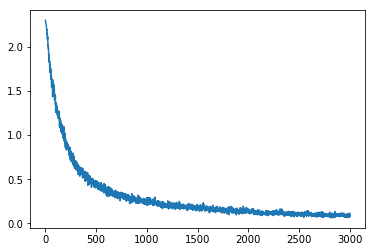

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

In [24]:
loss_track

[2.3003368,
 2.2889502,
 2.2850413,
 2.2748864,
 2.2703731,
 2.2673423,
 2.2566857,
 2.2453299,
 2.2410719,
 2.2351534,
 2.2234945,
 2.2128115,
 2.1971984,
 2.1846426,
 2.1983814,
 2.1678469,
 2.1685455,
 2.1337967,
 2.1348293,
 2.1523581,
 2.0821383,
 2.0933614,
 2.1138539,
 2.0825896,
 2.0139625,
 2.0120842,
 2.0004592,
 2.0242736,
 1.9941781,
 1.9801381,
 1.9836738,
 1.9493093,
 1.9226215,
 1.8802541,
 1.9159831,
 1.8562158,
 1.8766934,
 1.8796484,
 1.8341174,
 1.852098,
 1.8178946,
 1.8324205,
 1.7688894,
 1.7121878,
 1.8052138,
 1.7862794,
 1.7486801,
 1.7697558,
 1.7610954,
 1.7614144,
 1.7130306,
 1.7516283,
 1.6814686,
 1.6751093,
 1.728364,
 1.6760588,
 1.6265997,
 1.667724,
 1.6609944,
 1.6701747,
 1.6232169,
 1.5436041,
 1.6041431,
 1.5650789,
 1.6328917,
 1.5884993,
 1.5389982,
 1.6198275,
 1.5752089,
 1.5325781,
 1.6293771,
 1.4337755,
 1.6116514,
 1.5187585,
 1.5250646,
 1.5261227,
 1.529997,
 1.5826259,
 1.4981264,
 1.479038,
 1.4839875,
 1.4482758,
 1.488884,
 1.4609228